In [1]:
import csv
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_v2 as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
date = '0330_setting2_copy'
l1 = 0.3 
l2 = 0.2
m1 = 3
m2 = 2
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
#setting number 5 약간 꼬불꼬불?
xpoints = np.array([  0.5,1.5,2.0,1.5,1.0])#,2.0])
ypoints = np.array([  0.5,0.8,1.1,1.4,1.7])#,2.0])
xpoints = xpoints + 0.3
ypoints = ypoints + 0.5
Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints,Vpoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 500
V_size = 300
V_hidden_sizes = [V_size, V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.2
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 0#100000
alpha_kinematic = 0.01
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

In [3]:
f = open(date+'_total_data.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['xpoints'])
wr.writerow(xpoints)
wr.writerow(['ypoints'])
wr.writerow(ypoints)
wr.writerow(['T = ',T])
wr.writerow(['delta = ',delta])
wr.writerow(['num_timesteps = ',num_timesteps])
wr.writerow(['alpha = ',alpha])
wr.writerow(['tol =', tol ])
f.close()

# Ploting trajectory

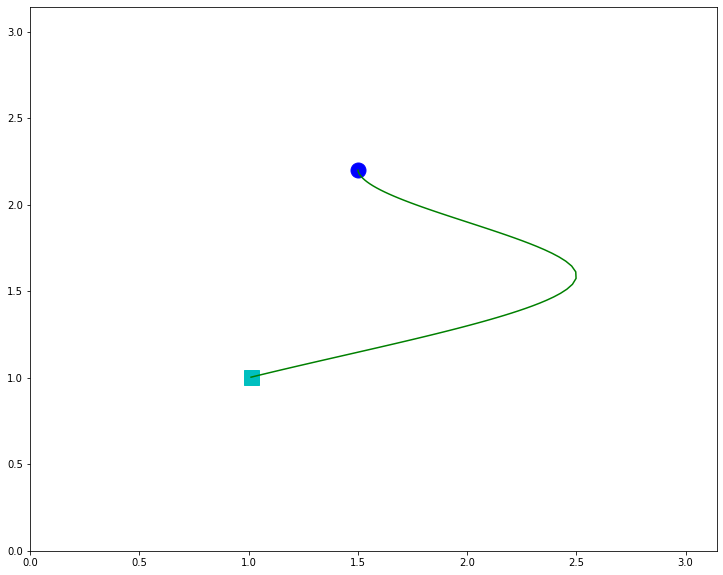

In [11]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

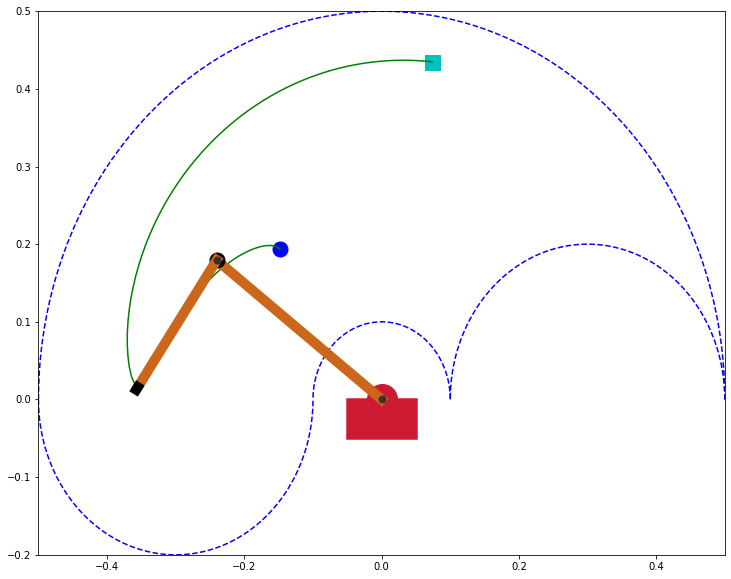

In [12]:
theta1 = xpoints[2]
theta2 = ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [14]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [15]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 648, loss = 1.2081033, loss_b = 1.0307157, loss_t = 1.2081033                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

KeyboardInterrupt: 

In [19]:
loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0039, device='cuda:0') tensor(19.9979, device='cuda:0', grad_fn=<MulBackward0>) tensor(522.2356) tensor(6.7110, device='cuda:0') tensor(11.5356, device='cuda:0')


In [20]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['No Regularization'])
wr.writerow(['loss_traj_1', 'loss_boundary_1', 'loss_Euc_1', 'loss_kinematic_1', 'loss_kinetic_1'])
wr.writerow([loss_traj_1.data.to(device_c).numpy(), loss_boundary_1.data.to(device_c).numpy(), loss_Euc_1.data.to(device_c).numpy(), loss_kinematic_1.data.to(device_c).numpy(), loss_kinetic_1.data.to(device_c).numpy()])
f.close()

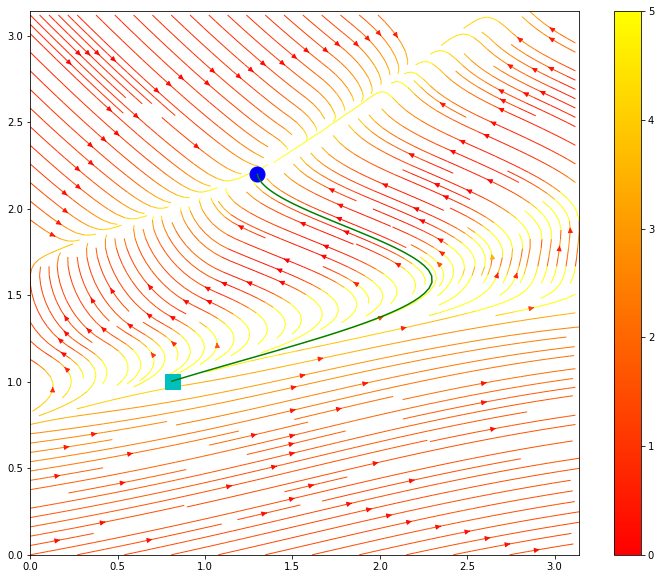

In [21]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

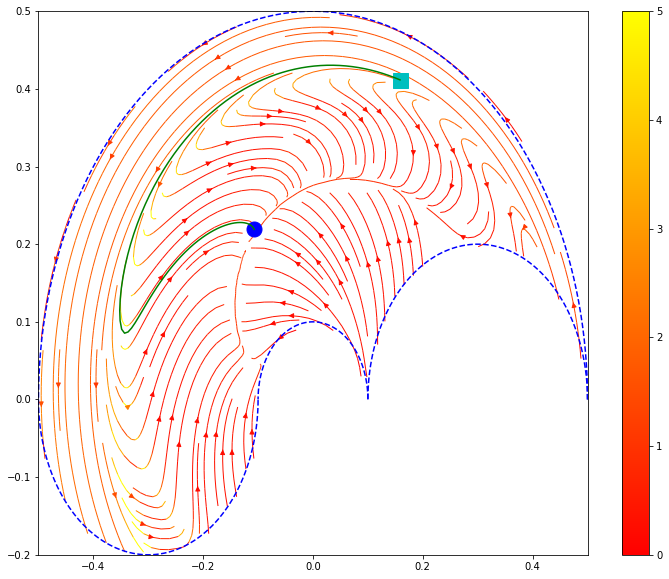

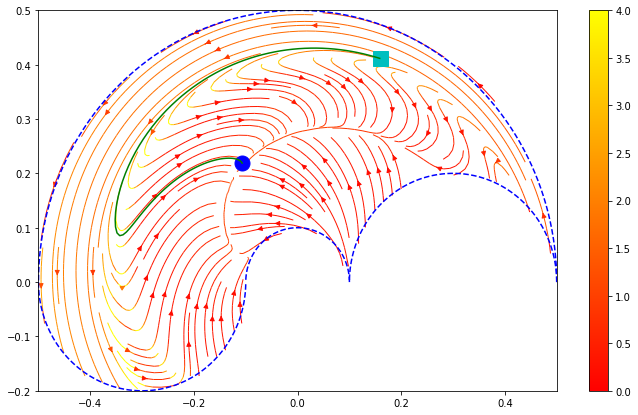

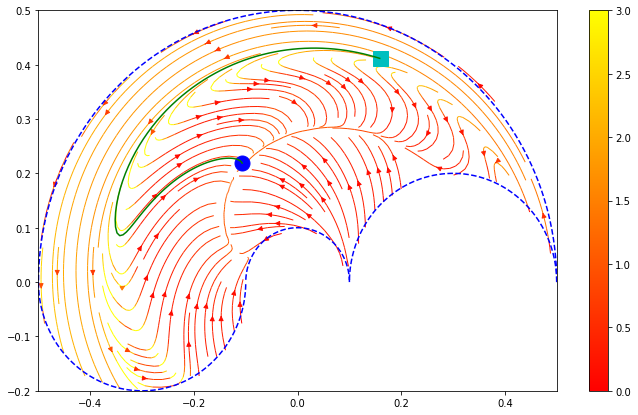

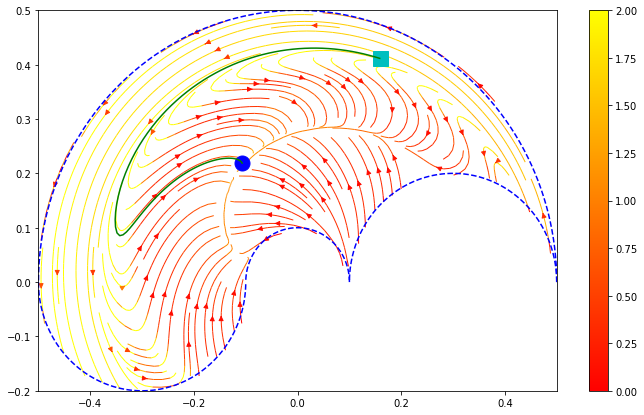

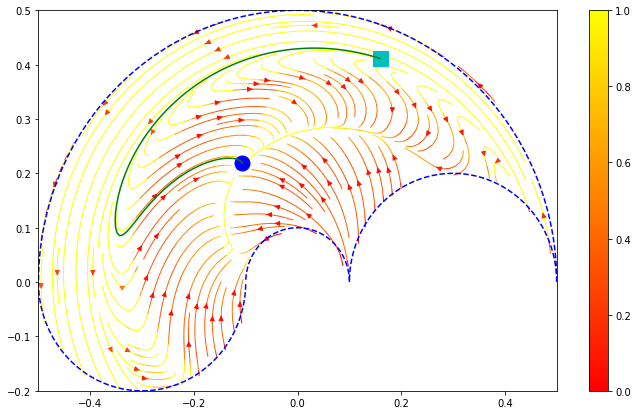

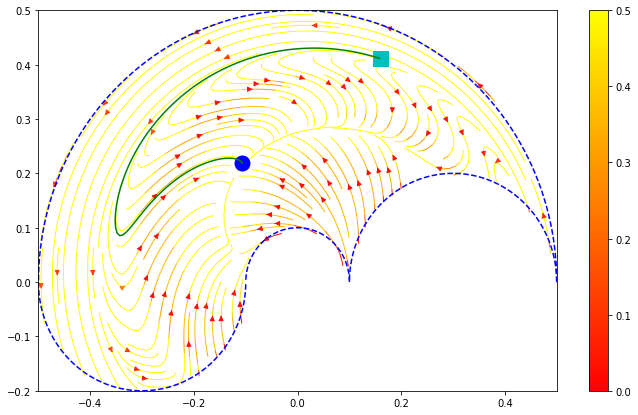

In [22]:
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

## weight norm decay

In [53]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [18]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 2777, loss = 0.00047899218, loss_b = 1.4950919, loss_t = 0.00047899218                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

In [23]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 4776, loss = 0.00018515914, loss_b = 1.980763, loss_t = 0.00018515914                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [24]:
loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0017, device='cuda:0') tensor(17.8308, device='cuda:0', grad_fn=<MulBackward0>) tensor(425.8005) tensor(3.6868, device='cuda:0') tensor(5.6252, device='cuda:0')


In [25]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Weight Regularization'])
wr.writerow(['loss_traj_2', 'loss_boundary_2', 'loss_Euc_2', 'loss_kinematic_2', 'loss_kinetic_2'])
wr.writerow([loss_traj_2.data.to(device_c).numpy(), loss_boundary_2.data.to(device_c).numpy(), loss_Euc_2.data.to(device_c).numpy(), loss_kinematic_2.data.to(device_c).numpy(), loss_kinetic_2.data.to(device_c).numpy()])
f.close()

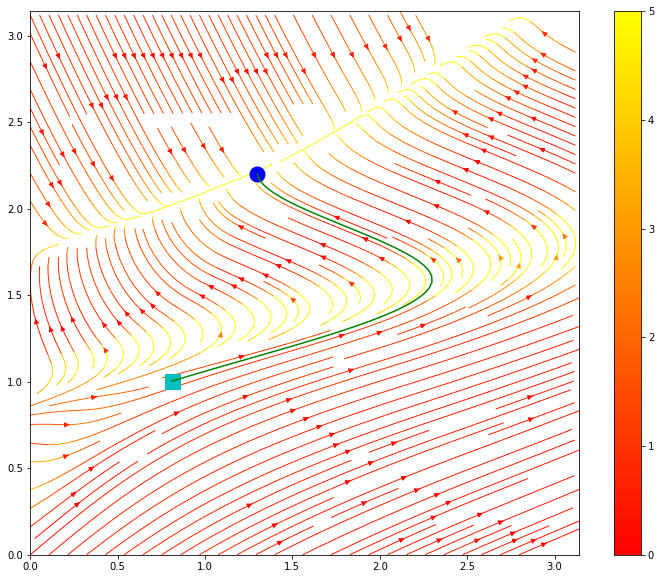

In [26]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

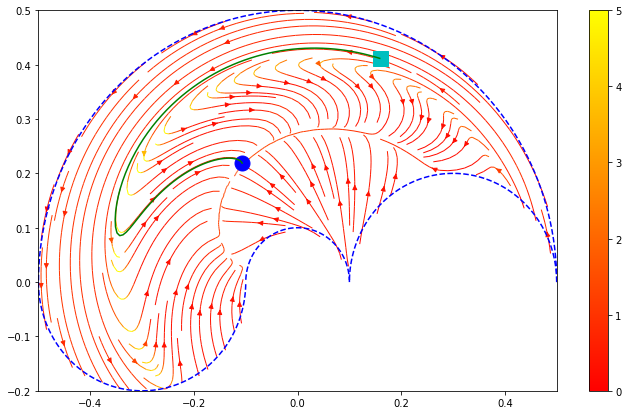

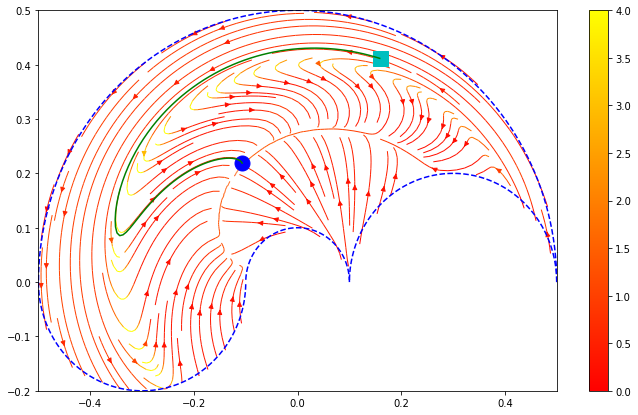

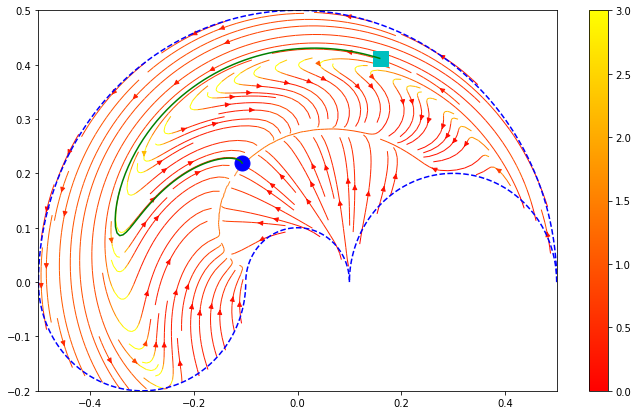

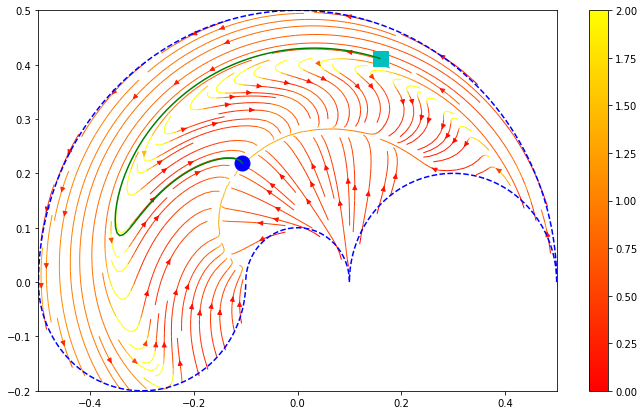

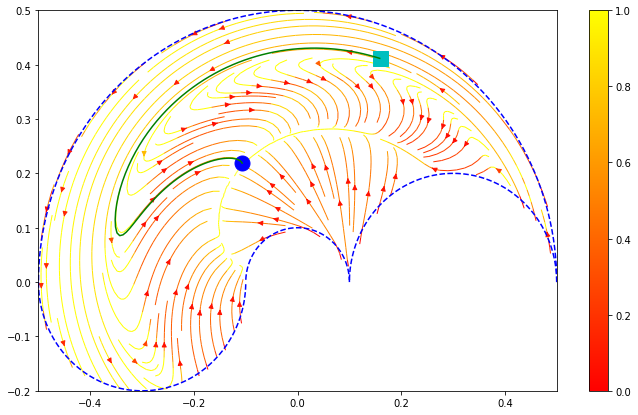

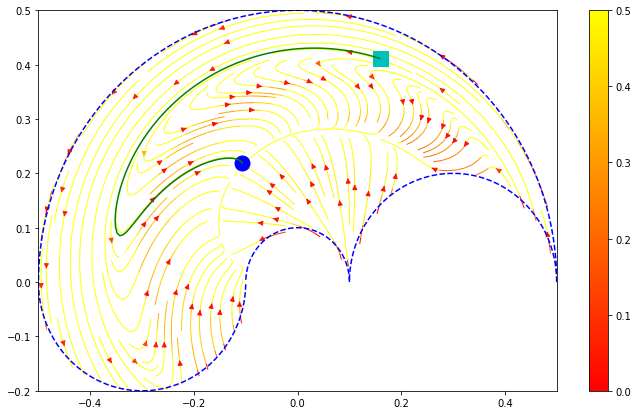

In [28]:
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Euclidean Regularization

In [10]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [11]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 9233, loss = 0.0005495005, loss_b = 1.6633934, loss_t = 0.0005495005                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [9]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 5323, loss = 0.0002064217, loss_b = 1.2976735, loss_t = 0.0002064217                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [35]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
penalty = 50
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 3e-6,epoch=1000000, batch_size = 400,penalty_mode = mode)

 i = 31, loss = 60.80234, total_loss = 72.80855, loss_t = 0.0031917682, loss_reg = 2.4267602, loss_reg_total =  14.432971           ..                             

KeyboardInterrupt: 

In [36]:
loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0349, device='cuda:0') tensor(13.7216, device='cuda:0', grad_fn=<MulBackward0>) tensor(129.8967) tensor(1.6263, device='cuda:0') tensor(2.9967, device='cuda:0')


In [37]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Euclidean Regularization'])
wr.writerow(['loss_traj_3', 'loss_boundary_3', 'loss_Euc_3', 'loss_kinematic_3', 'loss_kinetic_3'])
wr.writerow([loss_traj_3.data.to(device_c).numpy(), loss_boundary_3.data.to(device_c).numpy(), loss_Euc_3.data.to(device_c).numpy(), loss_kinematic_3.data.to(device_c).numpy(), loss_kinetic_3.data.to(device_c).numpy()])
f.close()

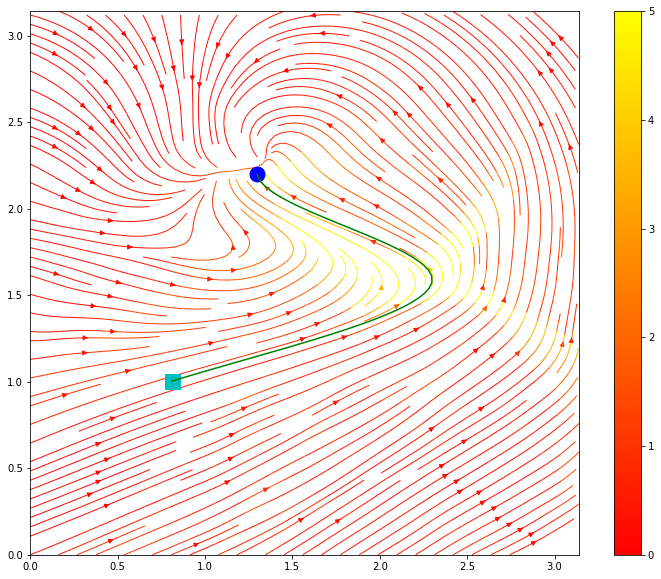

In [38]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

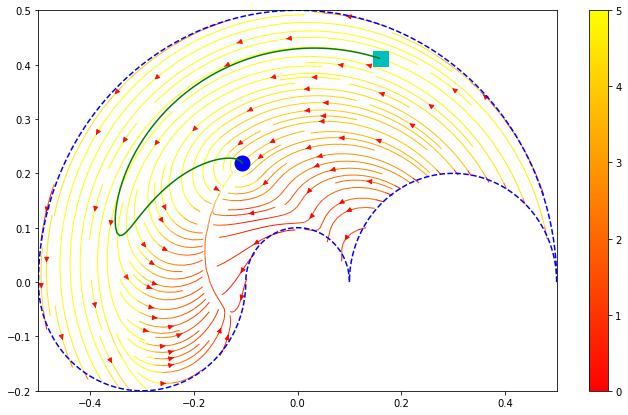

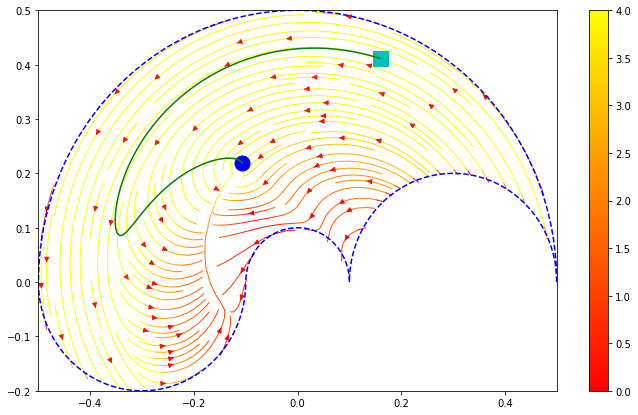

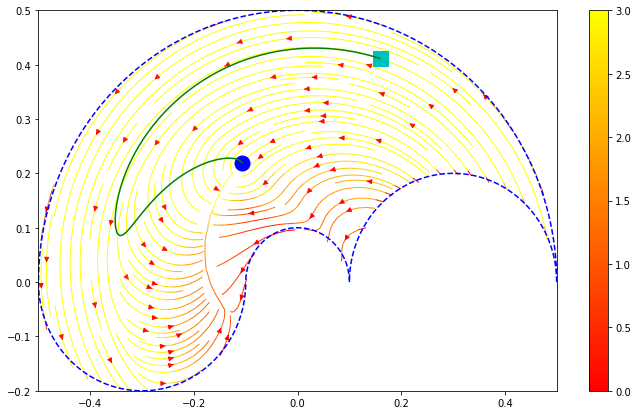

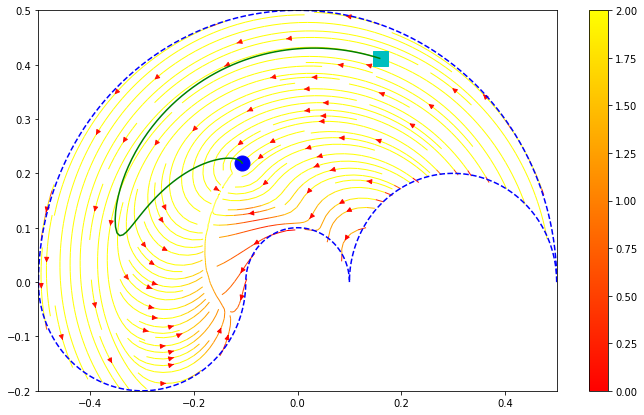

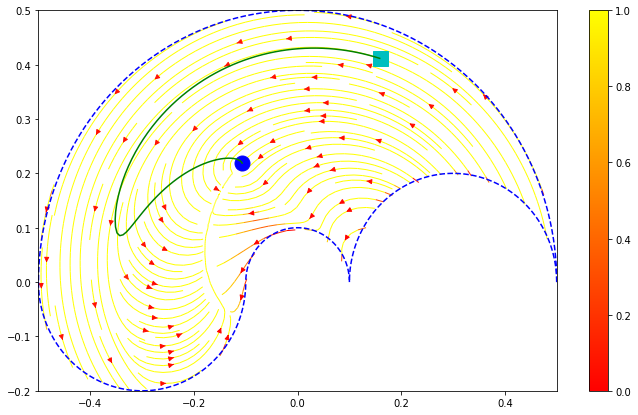

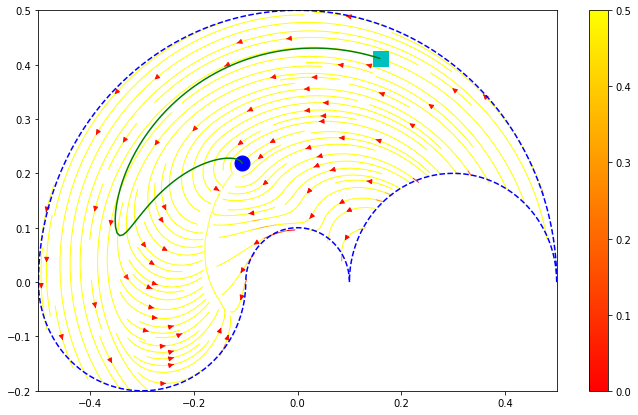

In [41]:
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinematic Regularization

In [42]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [43]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 10000, loss = 0.10346431, loss_b = 0.7825985, loss_t = 0.10346431                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [ ]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared

penalty = 10
penalty_boundary = 0
mode = 2
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 2e-6,epoch=150000, batch_size = 40,penalty_mode = mode)

 i = 8960, loss = 11.549207, total_loss = 11.60369, loss_b = 0.6155168, loss_t = 2.3223354e-05, loss_reg = 0.035119645, loss_reg_total =  0.089641765           .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [18]:
loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0009, device='cuda:0') tensor(21.9489, device='cuda:0', grad_fn=<MulBackward0>) tensor(581.5660) tensor(1.7952, device='cuda:0') tensor(4.1888, device='cuda:0')


In [15]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinematic Regularization'])
wr.writerow(['loss_traj_4', 'loss_boundary_4', 'loss_Euc_4', 'loss_kinematic_4', 'loss_kinetic_4'])
wr.writerow([loss_traj_4.data.to(device_c).numpy(), loss_boundary_4.data.to(device_c).numpy(), loss_Euc_4.data.to(device_c).numpy(), loss_kinematic_4.data.to(device_c).numpy(), loss_kinetic_4.data.to(device_c).numpy()])
f.close()

NameError: name 'loss_traj_4' is not defined

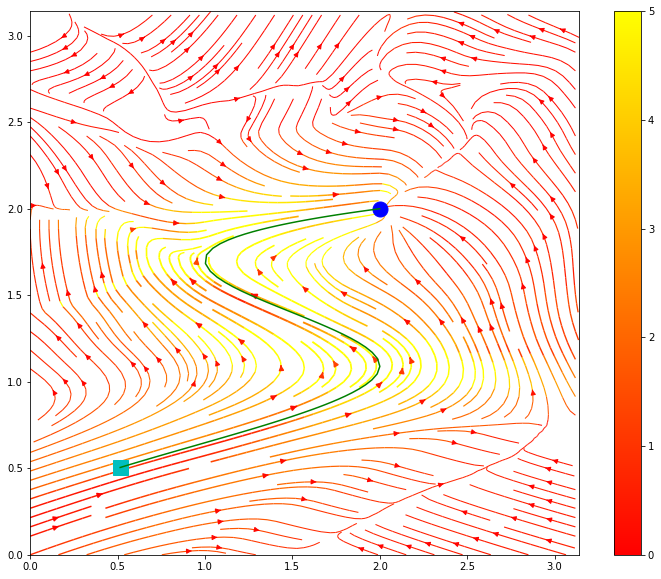

In [20]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

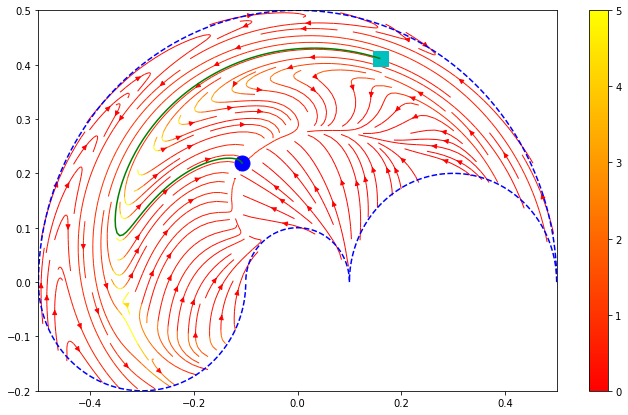

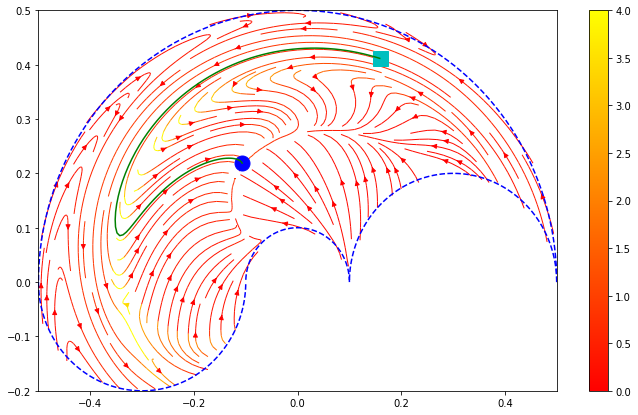

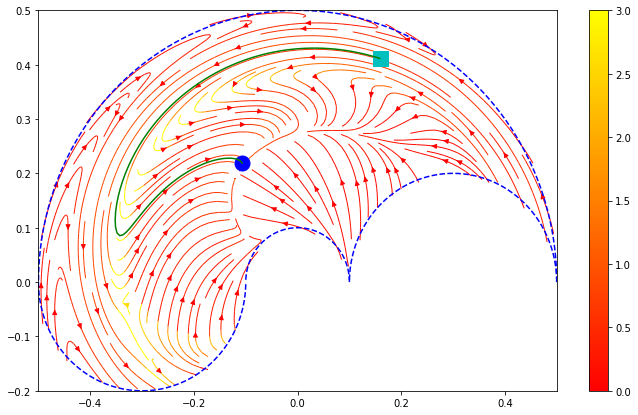

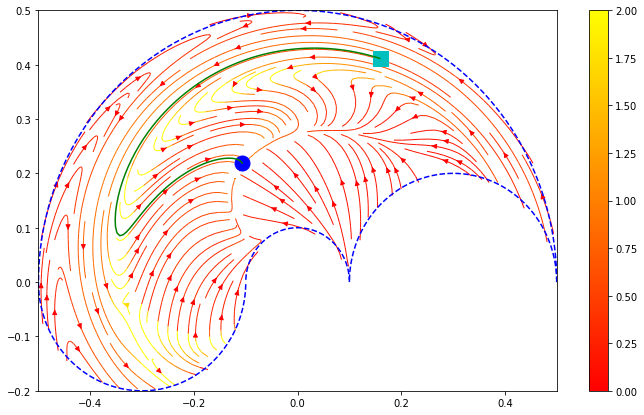

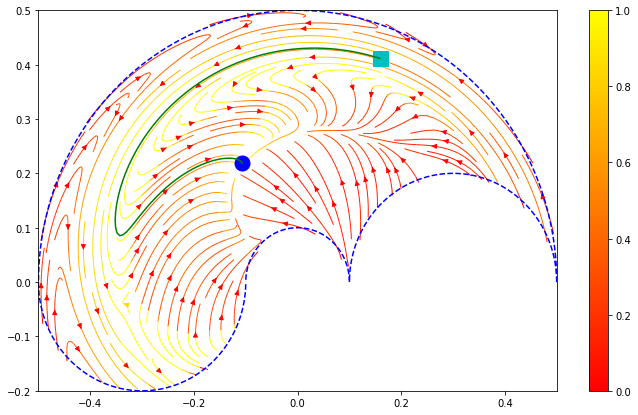

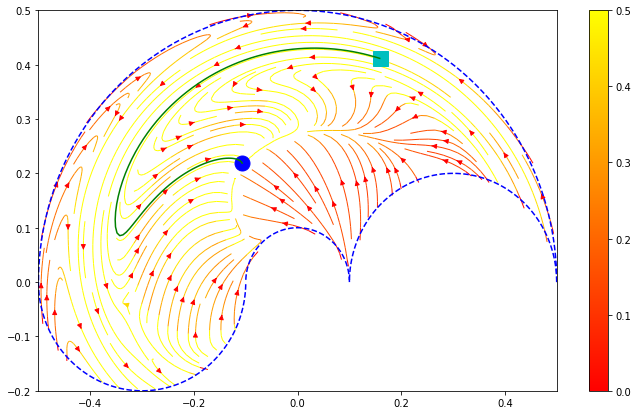

In [53]:
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinetic Regularization

In [6]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [7]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 355, loss = 0.0053993003, loss_b = 1.0055633, loss_t = 0.0053993003                    ..                                                                                                                                                                                                                                                                                                                                                          

KeyboardInterrupt: 

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [8]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
penalty = 10
penalty_boundary = 0
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-6,epoch=150000, batch_size = 40,penalty_mode = 2)

 i = 59200, loss = 11.535725, total_loss = 11.629513, loss_b = 0.009325848, loss_t = 2.4545896e-05, loss_reg = 0.021571836, loss_reg_total =  0.11520425           .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-cd0867ee7106>", line 5, in <module>
    optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-6,epoch=150000, batch_size = 40,penalty_mode = 2)
  File "C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\ICNN_optim_v2.py", line 631, in optim_Kinetic_reg
    Temp2 = robot.get_Kinetic_Riemannian_metric(current_grid_data[k,:])
  File "C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\robotarm.py", line 78, in get_Kinetic_Riemannian_metric
    Jacobian2 = self.get_jacobian(q)
  File "C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\robotarm.py", line 50, in get_jacobian
    Jacobian[0,0] = -self.l1*torch.sin(q[0])-self.l2*torch.sin(q[0]+q[1])
KeyboardInterrupt

Du

KeyboardInterrupt: 

In [9]:
loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0002, device='cuda:0') tensor(0.0870, device='cuda:0', grad_fn=<MulBackward0>) tensor(212.7652) tensor(0.7273, device='cuda:0') tensor(1.4224, device='cuda:0')


In [10]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinetic Regularization'])
wr.writerow(['loss_traj_5', 'loss_boundary_5', 'loss_Euc_5', 'loss_kinematic_5', 'loss_kinetic_5'])
wr.writerow([loss_traj_5.data.to(device_c).numpy(), loss_boundary_5.data.to(device_c).numpy(), loss_Euc_5.data.to(device_c).numpy(), loss_kinematic_5.data.to(device_c).numpy(), loss_kinetic_5.data.to(device_c).numpy()])
f.close()

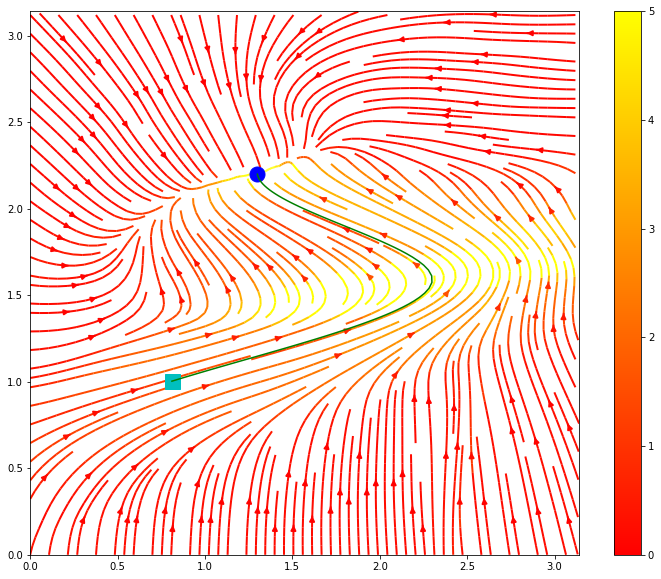

In [11]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\ICNN_plot.py:103: RuntimeWarning: invalid value encountered in arccos
  q1 = np.arccos(((self.l1+self.l2*np.cos(q2))*x1+(self.l2*np.sin(q2))*x2)/(self.l1**2+self.l2**2+2*self.l1*self.l2*np.cos(q2)))


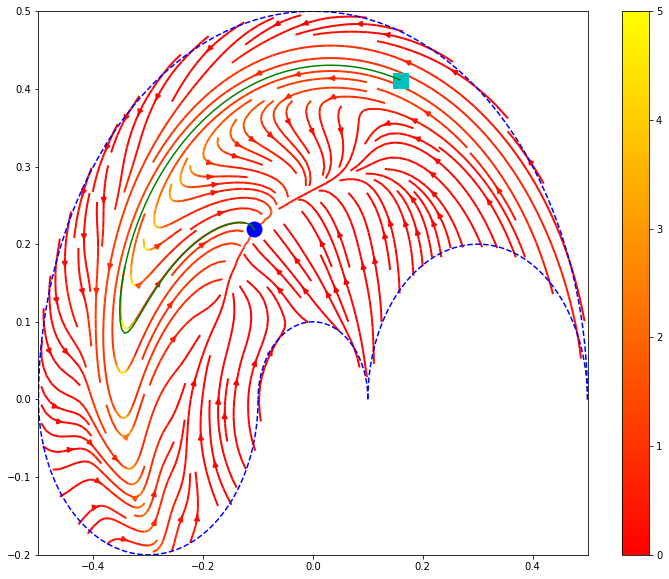

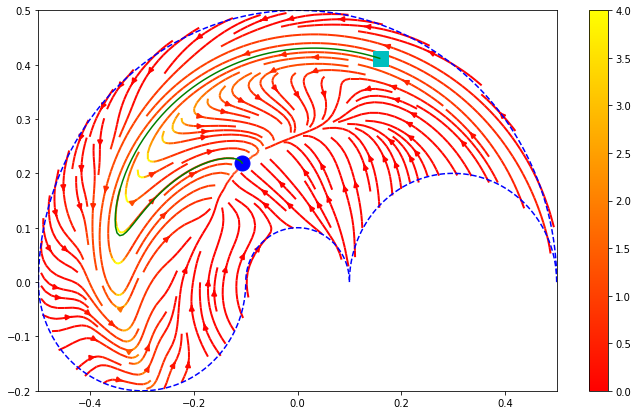

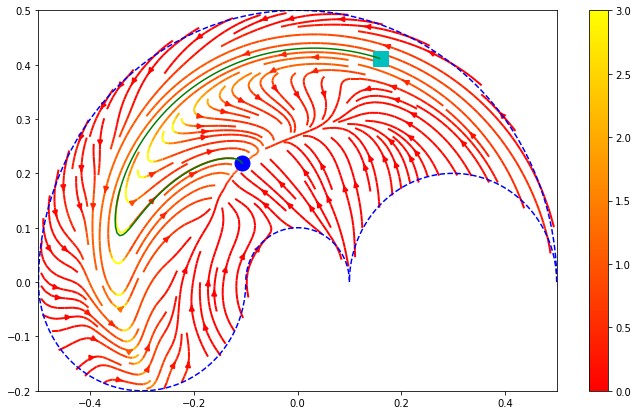

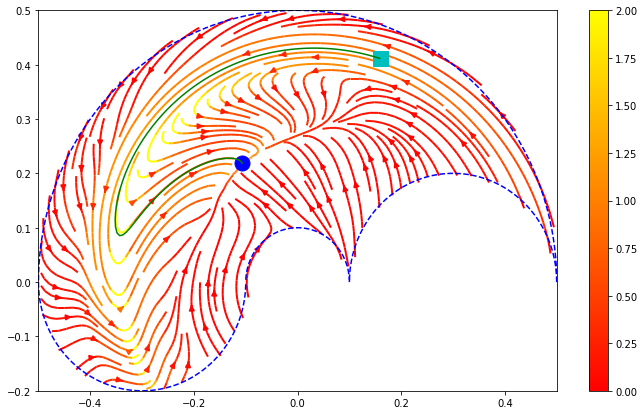

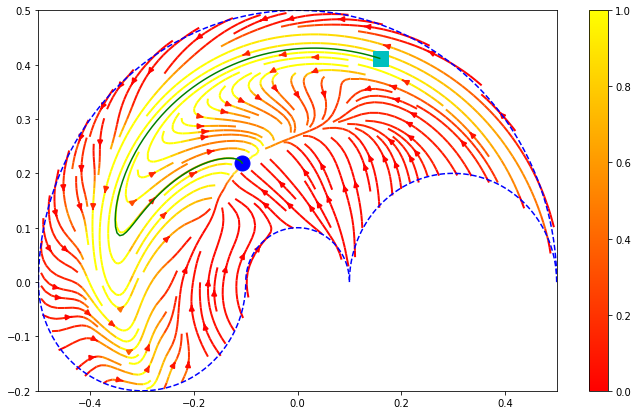

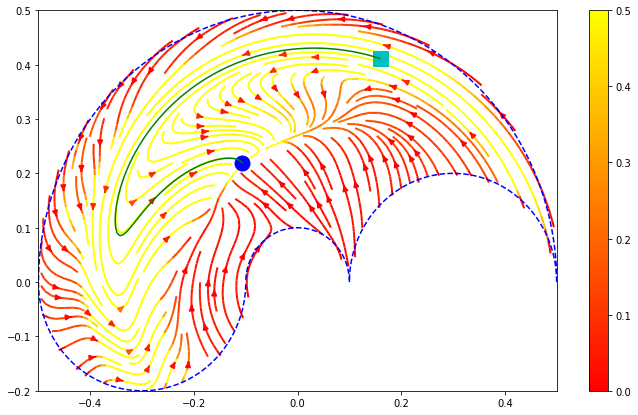

In [12]:
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

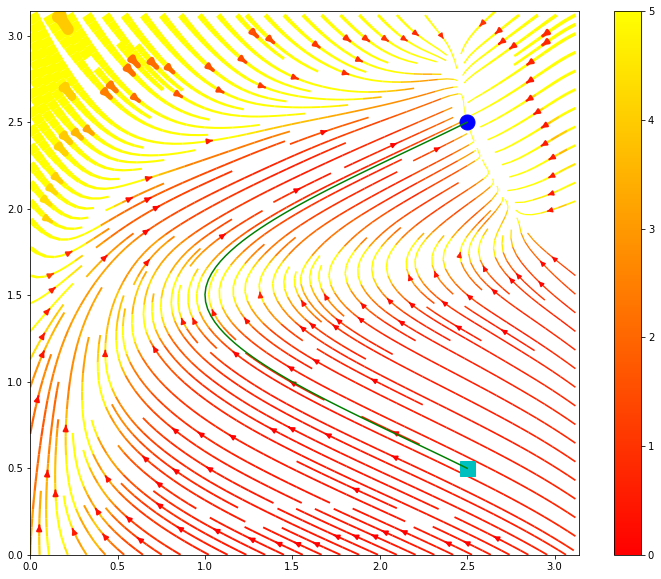

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

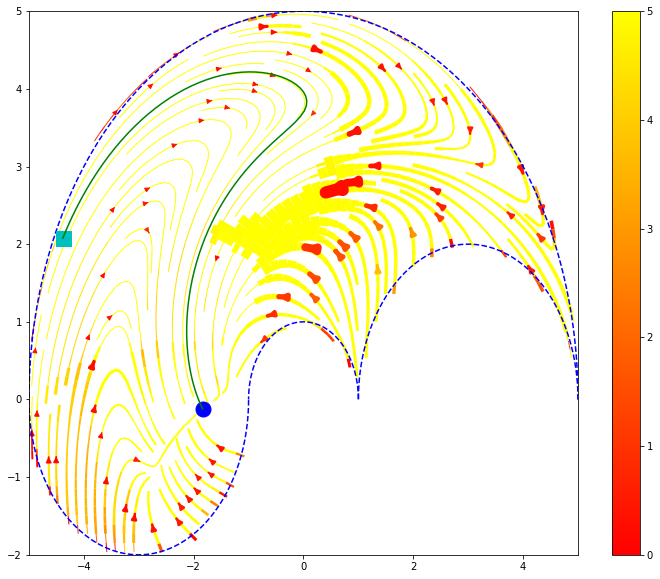

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'